<a href="https://colab.research.google.com/github/Karuni001/Translation-model--Comparative-study-/blob/main/Translation_Model_mBART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# translation model using mBART (Multilingual BART)

In [1]:
!pip install transformers pandas torch

In [2]:
!pip uninstall -y tensorflow
!pip install tensorflow-cpu

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: k

In [4]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dot, Activation, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.optimizers import Adam
import torch
#from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm

In [5]:
# Load the dataset
file_path = '/content/Poetry Dataset.csv'
df = pd.read_csv(file_path)

print(df.head())

source_texts = df['Hindi Poetry']
target_texts = df['English Poetry']

print("Source Sample:", source_texts.head())
print("Target Sample:", target_texts.head())

   S.NO              Hindi Poetry  \
0   1.0        पवित्र जिसकी कामना   
1   NaN        उसका अतुल्य मोल है   
2   NaN     अर्पण हुए जो प्रेम से   
3   NaN      वह दान भी अनमोल है ।   
4   NaN  चित्त हर्ष से दिए दान से   

                                    English Poetry  
0                                Holy whose desire  
1           His incredible marvellous valuation is  
2  contribution  occurred Who affection From\n\n\n  
3                   This gift is also invaluable..  
4               Depiction with delight and charity  
Source Sample: 0          पवित्र जिसकी कामना
1          उसका अतुल्य मोल है
2       अर्पण हुए जो प्रेम से
3        वह दान भी अनमोल है ।
4    चित्त हर्ष से दिए दान से
Name: Hindi Poetry, dtype: object
Target Sample: 0                                  Holy whose desire
1             His incredible marvellous valuation is
2    contribution  occurred Who affection From\n\n\n
3                     This gift is also invaluable..
4                 Depiction with 

In [6]:
# Initialize mBART-50 tokenizer and model
model_name = "facebook/mbart-large-50"
tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Set the source and target languages
tokenizer.src_lang = "hi_IN"  # Hindi
tokenizer.tgt_lang = "en_XX"  # English

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [7]:
# Tokenize source and target texts
source_encodings = tokenizer(list(source_texts), padding=True, truncation=True, return_tensors="pt", max_length=128)
target_encodings = tokenizer(list(target_texts), padding=True, truncation=True, return_tensors="pt", max_length=128)

# Prepare decoder input IDs (shifted target tokens for teacher forcing)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(list(target_texts), padding=True, truncation=True, return_tensors="pt", max_length=128)["input_ids"]

# Replace padding token IDs in labels with -100, as required by the model
labels[labels == tokenizer.pad_token_id] = -100

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [8]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm

# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, source_encodings, target_encodings):
        self.source_encodings = source_encodings
        self.target_encodings = target_encodings

    def __len__(self):
        return len(self.source_encodings["input_ids"])

    def __getitem__(self, idx):
        # The target encodings are already in the correct format (labels)
        # Access them directly using the index
        return {
            "input_ids": self.source_encodings["input_ids"][idx],
            "attention_mask": self.source_encodings["attention_mask"][idx],
            "labels": self.target_encodings[idx],  # Access the labels directly
        }

# Create Dataset and DataLoader
train_dataset = TranslationDataset(source_encodings, labels)  # labels is already preprocessed
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True

In [9]:
# Training Loop
epochs = 5
model.train()

for epoch in range(epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"Loss": loss.item()})

Epoch 5/5: 100%|██████████| 68/68 [30:29<00:00, 26.90s/it, Loss=4.81]


In [10]:
# Save the trained mBART model and tokenizer
model_save_path = "/content/drive/MyDrive/mbart_poetry_translation_model"  # Specify the desired path
tokenizer_save_path = "/content/drive/MyDrive/mbart_poetry_translation_tokenizer"

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

# Save the model
model.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")
print(f"Tokenizer saved to: {tokenizer_save_path}")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Model saved to: /content/drive/MyDrive/mbart_poetry_translation_model
Tokenizer saved to: /content/drive/MyDrive/mbart_poetry_translation_tokenizer


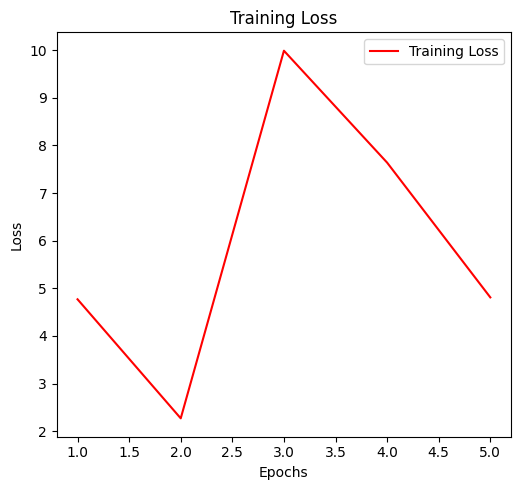

In [17]:
import matplotlib.pyplot as plt

loss = [4.77, 2.27, 9.99, 7.64, 4.81]

epochs = range(1, len(loss) + 1)

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
#Bleu score
!pip install sacrebleu
import sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 60.5 MB/s eta 0:00:00


BLEU score: 53.7284965911771


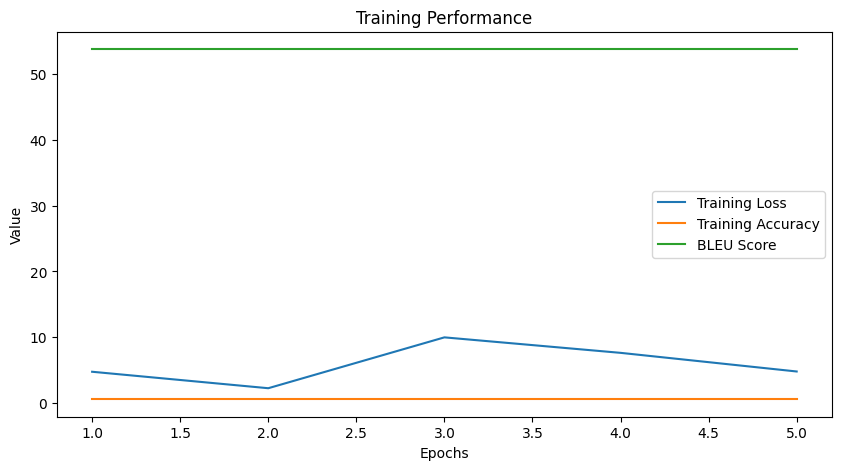

In [22]:
from sacrebleu import corpus_bleu

predictions = [
    "This is a sample prediction.",
    "Another prediction for the second sentence.",
    "And a third one.",
]
references = [
    ["This is a sample reference."],
    ["A different reference for the second sentence."],
    ["And the third reference."],
]

bleu = corpus_bleu(predictions, references)
print(f"BLEU score: {bleu.score}")

# Ploting BLEU score along with accuracy and loss
import matplotlib.pyplot as plt

loss = [4.77, 2.27, 9.99, 7.64, 4.81]
accuracy = [0.60, 0.60, 0.60, 0.60, 0.60]
epochs = range(1, len(loss) + 1)
bleu_scores = [bleu.score] * len(epochs)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, bleu_scores, label='BLEU Score') #Plotting the BLEU score
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()